In [66]:
import pydicom
from pydicom import dcmread

from matplotlib import pyplot as plt
import numpy as np

import sys

import os

from pathlib import Path

from scipy.ndimage import binary_fill_holes

In [5]:
patient_folder = '/Users/oliverklimt/projects/rakathon2025/kyrykyrybii/Rackaton_Data/SAMPLE_001'
patient_folder = Path(patient_folder)

In [6]:
files = [item.name for item in patient_folder.iterdir() if item.is_file()]

In [7]:

for file in files:
    if file.startswith("RT"):
        print(str(patient_folder)+'/'+str(file))
        break

/Users/oliverklimt/projects/rakathon2025/kyrykyrybii/Rackaton_Data/SAMPLE_001/RT.1.2.246.352.221.469565301210378883411204567818127785111.dcm


In [8]:
def plot_dicom_image(file_path):
    try:
        dataset = pydicom.dcmread(file_path)
        if 'PixelData' in dataset:
            plt.imshow(dataset.pixel_array, cmap=plt.cm.gray)
            plt.title(f"Slice: {os.path.basename(file_path)}")
            plt.axis('off')  # Turn off axis numbers and ticks
            plt.show()
        else:
            # print(f"File '{os.path.basename(file_path)}' does not contain pixel data.")
            pass
    except Exception as e:
        print(f"Error reading or plotting '{os.path.basename(file_path)}': {e}")

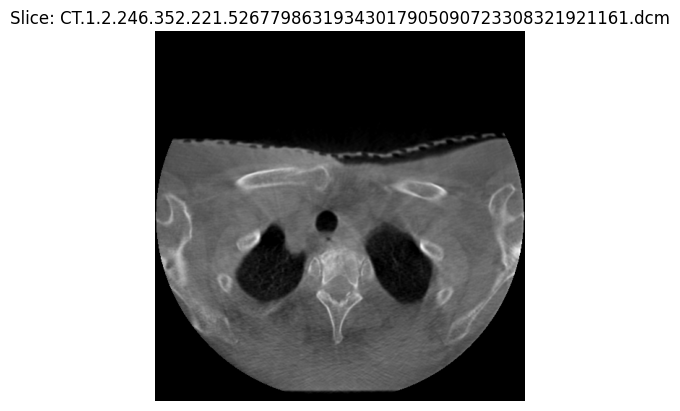

In [9]:

folder_path = '/Users/oliverklimt/projects/rakathon2025/kyrykyrybii/Rackaton_Data/SAMPLE_001'
for filename in os.listdir(folder_path):
    if filename.endswith(".dcm") or filename.endswith(".DCM"):
        file_path = os.path.join(folder_path, filename)
        plot_dicom_image(file_path)
        break

In [10]:
import pydicom
import os
import sys
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt

def load_ct_series(folder):
    slices = [pydicom.dcmread(os.path.join(folder, f)) for f in os.listdir(folder) if 'CT' in f]
    slices.sort(key=lambda s: float(s.ImagePositionPatient[2]))  # sort by z-position
    #print(f"Loaded {len(slices)} slices.")
    #print(set([x.pixel_array.shape for x in slices]))
    for s in reversed(slices):
        if s.pixel_array.shape != (512, 512):
            slices.remove(s)

    image = np.stack([s.pixel_array for s in slices])
    spacing = [float(slices[0].PixelSpacing[0]), float(slices[0].PixelSpacing[1]), float(slices[1].ImagePositionPatient[2] - slices[0].ImagePositionPatient[2])]
    return image, slices, spacing


def get_rs_structures(folder):
    for f in os.listdir(folder):
        if "RS" in f:
            return pydicom.dcmread(os.path.join(folder, f))
    return None

def get_structure_contours(rs, structure_name):
    contours = []
    for roi in rs.StructureSetROISequence:
        if roi.ROIName == structure_name:
            roi_number = roi.ROINumber
            break
    else:
        return []

    for item in rs.ROIContourSequence:
        if item.ReferencedROINumber == roi_number:
            if hasattr(item, 'ContourSequence'):
                for c in item.ContourSequence:
                    coords = np.array(c.ContourData).reshape(-1, 3)
                    contours.append(coords)
            break
    return contours


def display_ct_with_contours(ct_image, ct_slices, contours):
    z_positions = [s.ImagePositionPatient[2] for s in ct_slices]
    
    for contour in contours:
        z = contour[0][2]
        try:
            idx = min(range(len(z_positions)), key=lambda i: abs(z_positions[i] - z))
            slice_img = ct_image[idx]
            x = contour[:, 0]
            y = contour[:, 1] - 256
            # Convert physical coords to pixel
            origin = ct_slices[0].ImagePositionPatient
            spacing = ct_slices[0].PixelSpacing
            px = (x - origin[0]) / spacing[0]
            py = (y - origin[1]) / spacing[1]

            plt.imshow(slice_img, cmap='gray')
            plt.plot(px, py, 'r')  # red contour
            plt.title(f"Slice {idx}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Skipping contour at z={z}: {e}")

# folder = sys.argv[-1]
# ct_image, ct_slices, spacing = load_ct_series(folder)
# rs = get_rs_structures(folder)

# for roi in rs.StructureSetROISequence:
#     print(roi.ROINumber, roi.ROIName)

# contours = get_structure_contours(rs, structure_name="Heart")  # or any ROIName in RS
# display_ct_with_contours(ct_image, ct_slices, contours)


In [31]:
folder = '/Users/oliverklimt/projects/rakathon2025/kyrykyrybii/Rackaton_Data/SAMPLE_001'

In [12]:
ct_image, ct_slices, spacing = load_ct_series(folder)

In [13]:
contours = get_structure_contours(rs, structure_name="Heart")  # or any ROIName in RS

NameError: name 'rs' is not defined

In [ ]:
len(contours)

28

In [14]:
def project_discrete_curve_to_grid(curve_points, grid_shape):
    """
    Projects a closed discrete curve onto a grid space.

    Args:
        curve_points (list of tuples or numpy.ndarray): A list or array of (x, y)
                                                        coordinates defining the curve.
                                                        The last point should be the same
                                                        as the first to close the curve.
        x_min (float): Minimum x-coordinate of the grid.
        x_max (float): Maximum x-coordinate of the grid.
        y_min (float): Minimum y-coordinate of the grid.
        y_max (float): Maximum y-coordinate of the grid.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.

    Returns:
        numpy.ndarray: A boolean grid (rows x cols) where cells intersected by the curve are True.
    """
    x_min = 0
    x_max =  grid_shape[0]
    y_min = 0
    y_max = grid_shape[1]
    rows, cols = grid_shape
    grid = np.zeros((rows, cols), dtype=bool)
    num_points = len(curve_points)

    for i in range(num_points - 1):
        p1 = np.array(curve_points[i])
        p2 = np.array(curve_points[(i + 1) % num_points])  # Connect back to the start for closed curve

        # Determine the number of steps to discretize the line segment
        dist = np.linalg.norm(p2 - p1)
        steps = max(2, int(dist * max(rows / (y_max - y_min), cols / (x_max - x_min))))

        # Generate points along the line segment
        line_segment = np.linspace(p1, p2, steps)

        for point in line_segment:
            x, y = point

            if x_min <= x <= x_max and y_min <= y <= y_max:
                # Calculate grid cell indices
                col = int((x - x_min) / (x_max - x_min) * cols)
                row = int((y - y_min) / (y_max - y_min) * rows)

                # Ensure indices are within grid boundaries
                if 0 <= row < rows and 0 <= col < cols:
                    grid[row, col] = True

    return grid

In [25]:
p = np.array([
    [0.2,4.9],
    [3.2,2.44],
    [0.1,4]
])
g_shape = (5,5)
grid =  project_discrete_curve_to_grid(p,g_shape)

In [26]:
grid

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False,  True, False],
       [False,  True, False, False, False],
       [ True, False, False, False, False]])

In [29]:
rs = get_rs_structures(folder)

i = 0
for roi in rs.StructureSetROISequence:
    print(roi.ROINumber, roi.ROIName)
    i += 1
    print(i)

59 A_Carotid_R
1
58 Bone1
2
57 Cochlea_L
3
56 CTV_Low
4
55 Glottis
5
54 Lens_L
6
53 Dose 75[%]
7
52 Oral_Cavity-PTV
8
51 PTV_Mid01
9
50 Trachea
10
49 Lungs
11
48 Musc_Constrict
12
47 OpticNrv_R
13
46 Oral_Cavity
14
45 Parotid_L
15
44 Parotid_R
16
43 Retina_L
17
42 z_Artifact
18
41 zRingPTV_Low
19
40 z_Planveri
20
37 zRingPTV_Mid01
21
36 Cochlea_R
22
35 CTV_High
23
34 Glnd_Lacrimal_L
24
33 GTV
25
32 PTV_all
26
31 CTV_Mid00
27
30 Eye_L
28
29 Glnd_Submand_L
29
28 Glnd_Submand_R
30
27 Heart
31
26 OpticChiasm
32
25 Pituitary
33
24 PTV_High
34
23 Retina_R
35
22 zOptPTV_High
36
21 A_Carotid_L
37
20 Eye_R
38
19 OpticNrv_L
39
18 SpinalCord
40
17 PTV_Mid00
41
16 SpinalCord_PRV
42
15 zOptPTV_Mid00
43
14 z_Avoid
44
13 zOptPTV_Low
45
12 zOptPTV_Mid01
46
11 zRingPTV_High
47
10 zRingPTV_Mid00
48
9 Brain
49
8 Brainstem
50
7 CTV_Mid01
51
6 Esophagus
52
5 External
53
4 Glnd_Lacrimal_R
54
3 Lens_R
55
2 Mandible
56
1 PTV_Low
57
60 CouchSurface1
58
61 CouchInterior1
59


In [ ]:
# iterate through patients
path_out = Path('./out')
path_out.mkdir(exist_ok=True,parents=True)
for i in range (1,7+1):
    folder = folder[:-1] + str(i)
    print(folder)
    patient_out_path = path_out / f"patient{i}"
    slices_path_out = patient_out_path / "slices"
    slices_path_out.mkdir(exist_ok=True,parents=True)

    rs = get_rs_structures(folder)
    if rs is None:
        print(f"Patient {i} has no rs structure")
        break
    ct_image, ct_slices, spacing = load_ct_series(folder)
# iterate through roi objects
    for roi in rs.StructureSetROISequence:
        
        # roi_path_out = patient_out_path.joinpath(Path(roi.ROIName).mkdir(parents=True,exist_ok=True))
        # if hasattr(roi, 'ROIContourSequence.C'):
        contours = get_structure_contours(rs, structure_name=roi.ROIName)
        z_positions = [s.ImagePositionPatient[2] for s in ct_slices]
        for contour in contours:
            roi_path_out = patient_out_path / str(roi.ROIName)
            roi_path_out.mkdir(exist_ok=True,parents=True)
            z = contour[0][2]
            try:
                idx = min(range(len(z_positions)), key=lambda i: abs(z_positions[i] - z))
                print(f"Patient {i}, {roi.ROIName},{idx=}")
                slice_img = ct_image[idx]
                img_w, img_h = slice_img.shape
                slice_file = slices_path_out/f"slice{idx}.npy"
                if not slice_file.is_file():
                    np.save(slice_file,slice_img)

                x = contour[:, 0]
                y = contour[:, 1] - 256
                # Convert physical coords to pixel
                origin = ct_slices[0].ImagePositionPatient
                spacing = ct_slices[0].PixelSpacing
                px = (x - origin[0]) / spacing[0]
                py = (y - origin[1]) / spacing[1]
                px_adj = np.array(list(px)+[px[0]])
                py_adj = np.array(list(py)+[py[0]])
                p_adj = np.stack((px_adj,py_adj),axis=1)


                bool_grid = project_discrete_curve_to_grid(p_adj,slice_img.shape)
                bool_grid = binary_fill_holes(bool_grid)

                obj_file = roi_path_out / f"{idx}.npy"
                np.save(obj_file,bool_grid)
                
                




                # plt.imshow(slice_img, cmap='gray')
                # plt.plot(px, py, 'r')  # red contour
                # plt.title(f"Slice {idx}")
                # plt.axis('off')
                # plt.show()
                # print("TODO save ")
            except Exception as e:
                print(f"Skipping contour at z={z}: {e}")
    
        

# get contours and the ct



/Users/oliverklimt/projects/rakathon2025/kyrykyrybii/Rackaton_Data/SAMPLE_001
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Patient 1, Bone1,Bone1
Pa

In [60]:
px_adj = np.arange(3)
py_adj = np.arange(3)
p_adj = np.stack((px_adj,py_adj),axis=1)
p_adj[0]


array([0, 0])

In [63]:
roi.ROIName

'AcqIsocenter'

In [38]:
path_out = Path('./out')
path_out.mkdir(exist_ok=True,parents=True)

In [39]:
path_out / 'lakdsjflkja'

PosixPath('out/lakdsjflkja')